# Based off ERA5_Test
* Calculating seasonality based of 30 years of data
* Repeating with monthly averaged
* So one value per month and no 1pm threshold
* Testing next for monthly-averaged-by-hour

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from pathlib import Path
import glob
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cf
states_provinces = cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none')
import string  
lower = list(string.ascii_lowercase)  
capital = list(string.ascii_uppercase)  

In [2]:
import healpy as hp
import easygems.healpix as egh
import osmnx as ox
import geopandas as gpd 
from geopy.distance import geodesic
import intake
from cartopy.io import shapereader as shpreader
from cartopy.feature import ShapelyFeature
from shapely.geometry import MultiPolygon, Polygon, Point
from rasterio import features


In [36]:
path_era='/g/data/rt52/era5/single-levels/monthly-averaged-by-hour/'
path_um='/g/data/qx55/uk_node/glm.n2560_RAL3p3/'
plot_path='/home/561/dc5055/WCRP_HK25/Plots'

In [37]:
var='2t'
varname_era='t2m'

In [38]:
city_name='Brisbane'
city_lat = float('-27.47')
city_lon = float('153.03') 
rat_buff=3 # Ratio of buffer radius to max city radius

### Landmask

In [39]:
file_land=sorted(Path(path_era).glob(f'lsm/*/*.nc'))
ds_land=xr.open_mfdataset(file_land[0], chunks=-1)
lsm=ds_land['lsm'][0]

In [58]:
start_y='1990'
end_y='2020'

In [49]:
len(file_era)

793

In [59]:
file_era=sorted(Path(path_era).glob(f'{var}/*/*.nc'))
# list(file_era)
ds_era=xr.open_mfdataset(file_era[:744], chunks=-1)[varname_era].sel(time=slice(start_y, end_y))
ds_era

<xarray.DataArray 't2m' (time: 8928, latitude: 721, longitude: 1440)> Size: 74GB
dask.array<getitem, shape=(8928, 721, 1440), dtype=float64, chunksize=(24, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 71kB 1990-01-01 ... 2020-12-01T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

In [60]:
ds_era.time

<xarray.DataArray 'time' (time: 8928)> Size: 71kB
array(['1990-01-01T00:00:00.000000000', '1990-01-01T01:00:00.000000000',
       '1990-01-01T02:00:00.000000000', ..., '2020-12-01T21:00:00.000000000',
       '2020-12-01T22:00:00.000000000', '2020-12-01T23:00:00.000000000'],
      shape=(8928,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 71kB 1990-01-01 ... 2020-12-01T23:00:00
Attributes:
    long_name:  time

### Subsetting area around city for faster processing
* Notice latitude slicing needs to be counterintuitive

In [65]:
var_era_tmp=ds_era.where(lsm>0).sel(longitude=slice(city_lon-10, city_lon+10), latitude=slice(city_lat+5, city_lat-5))

In [66]:
var_era=var_era_tmp[3:][::24]
var_era.time

<xarray.DataArray 'time' (time: 372)> Size: 3kB
array(['1990-01-01T03:00:00.000000000', '1990-02-01T03:00:00.000000000',
       '1990-03-01T03:00:00.000000000', ..., '2020-10-01T03:00:00.000000000',
       '2020-11-01T03:00:00.000000000', '2020-12-01T03:00:00.000000000'],
      shape=(372,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 3kB 1990-01-01T03:00:00 ... 2020-12-01T03:...
Attributes:
    long_name:  time

## Function to subset city

### Function to create circle

In [67]:
def create_circle(center_lat, center_lon , radius_km, num_points=360):
    angles = np.linspace(0, 360, num_points)
    circle_lats, circle_lons = [], []
    for angle in angles:
        dest = geodesic(kilometers=radius_km).destination((center_lat, center_lon), angle)
        circle_lats.append(dest.latitude)
        circle_lons.append(dest.longitude)
    return circle_lons, circle_lats


### Masking city, buffer and UHI

In [68]:
def uhi(var_era, rat_buff):
    gdf = ox.geocode_to_gdf(city_name)
    geom = gdf.loc[0, 'geometry']
    # If it's a MultiPolygon, get the largest one by area
    if isinstance(geom, MultiPolygon):
        city_poly = max(geom.geoms, key=lambda a: a.area)
    elif isinstance(geom, Polygon):
        city_poly = geom
    else:
        raise TypeError("Geometry is not a Polygon or MultiPolygon")
    gdf_city = gpd.GeoDataFrame(index=[0], geometry=[city_poly], crs=gdf.crs)
    gdf_city_proj = gdf_city.to_crs(epsg=3857) 
    geom_city = gdf_city_proj.geometry[0]
    # city_geometry = geom_city.geometry.iloc[0]  # Extract the first geometry
    
    # Computing max radius and centroid
    centroid_city=city_poly.centroid
    boundary_coords = np.array(city_poly.exterior.coords)
    distances_m = [
        geodesic((centroid_city.y, centroid_city.x), (lat, lon)).meters
        for lon, lat in boundary_coords  # coords = (lon, lat)
    ]
    radius_m = max(distances_m)
    radius_km = radius_m / 1000
    center_lat, center_lon = centroid_city.y, centroid_city.x
    print(f"Area of city: {geom_city.area/1e6:.2f} km²")
    print(f"Radius of city: {radius_km:.2f} km")

# Masking points inside city polygon
    print(f'Calculating mask and values over city area')
    tmp = var_era.rio.write_crs("EPSG:4326", inplace=True)
    tmp = tmp.rename({'longitude':'x', 'latitude':'y'})
    gdf = gdf.to_crs(tmp.rio.crs)
    
    lat_2d, lon_2d = xr.broadcast(var_era['latitude'], var_era['longitude'])
    mask_land_2d=~np.isnan(var_era[0].values)
    land_lons = lon_2d.values[mask_land_2d]
    land_lats = lat_2d.values[mask_land_2d]
    points = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(land_lons, land_lats)], crs="EPSG:4326")
    inside_city = points.within(city_poly)
    pts_inside_city = points[inside_city]

    mask = features.rasterize(
        [(geom, 1) for geom in gdf_city["geometry"]],
        out_shape=tmp.rio.shape,
        transform=tmp.rio.transform(),
        fill=0,
        dtype='uint8'
    )
    
    mask_city = xr.DataArray(mask, dims=("latitude", "longitude"), 
                             coords={"latitude": tmp.y.values, "longitude": tmp.x.values})
    var_city = var_era.where(mask_city == 1)   # this is masking 

# Masking points inside buffer zone but outside city polygon
    print(f'Calculating mask and values over buffer ({rat_buff * radius_km:.2f} km circle) minus city area')
    rad_buff = rat_buff * radius_km
    buff_circle_lons, buff_circle_lats = create_circle(center_lat, center_lon, rad_buff)
    buff_circle_polygon = Polygon(zip(buff_circle_lons, buff_circle_lats))  # For masking
    
    gdf_buff = gpd.GeoDataFrame(index=[0], geometry=[buff_circle_polygon], crs=gdf.crs)
    mask = features.rasterize(
        [(geom, 1) for geom in gdf_buff["geometry"]],
        out_shape=tmp.rio.shape,
        transform=tmp.rio.transform(),
        fill=0,
        dtype='uint8'
    )
    
    mask_buff_circle = xr.DataArray(mask, dims=("latitude", "longitude"), 
                                    coords={"latitude": tmp.y.values, "longitude": tmp.x.values})
    var_buff = var_era.where((mask_buff_circle == 1) & (mask_city == 0))   # this is masking 

    uhi_timeseries = var_city.mean(('latitude', 'longitude'))-var_buff.mean(('latitude', 'longitude'))
    print(f'Finished calculating timeseries of UHI over {city_name} for {varname_era}')
    return uhi_timeseries, var_city, var_buff, rad_buff

In [69]:
uhi_timeseries, var_city, var_buff, rad_buff=uhi(var_era, rat_buff)

Area of city: 1520.48 km²
Radius of city: 33.14 km
Calculating mask and values over city area
Calculating mask and values over buffer (99.41 km circle) minus city area
Finished calculating timeseries of UHI over Brisbane for t2m


In [70]:
uhi_timeseries

<xarray.DataArray 't2m' (time: 372)> Size: 3kB
dask.array<sub, shape=(372,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 3kB 1990-01-01T03:00:00 ... 2020-12-01...
    spatial_ref  int64 8B 0

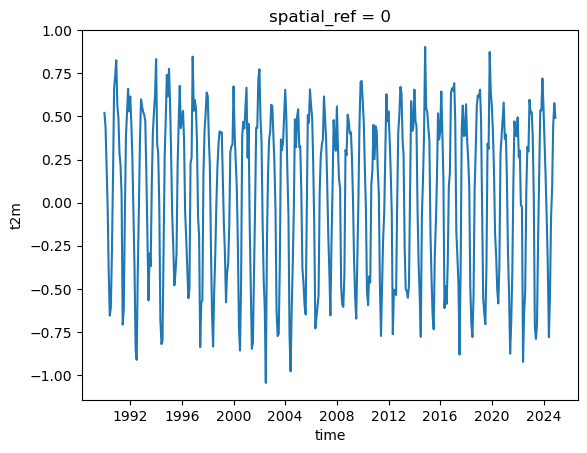

In [34]:
uhi_timeseries.plot()

### Temporary plot for monthly UHI

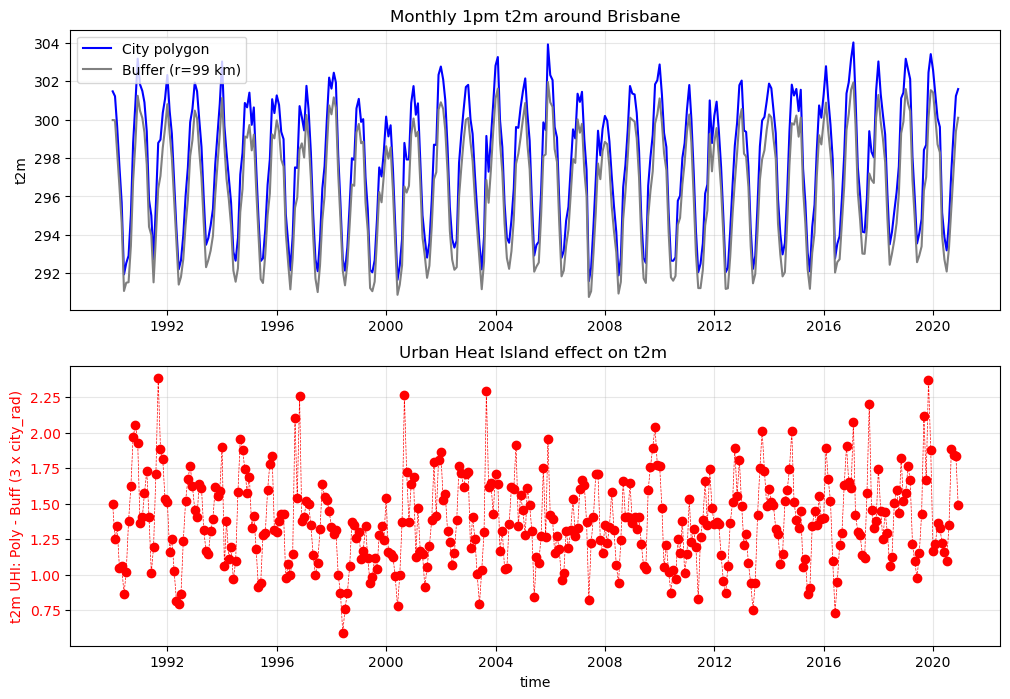

In [71]:
fig=plt.figure(figsize=(12, 8))

ax1=plt.subplot(211)
# Might add something to remove 273.15 from temperature data in Kelvins
ax1.grid(alpha=0.3)
(var_city.mean(dim=('latitude','longitude'))).plot(ax=ax1, color='blue', label='City polygon')
(var_buff.mean(dim=('latitude','longitude'))).plot(ax=ax1, color='grey', label='Buffer (r=%.0f km)' %(rad_buff))
plt.title(f"Monthly 1pm {varname_era} around {city_name}")
# plt.ylabel('TS (˚C)')
plt.xlabel('')
plt.legend()

ax2=plt.subplot(212)
ax2.grid(alpha=0.3)
(uhi_timeseries).plot(ax=ax2, linewidth=0.5, linestyle='--', marker='o',color='r', label='UHI')
plt.ylabel(f'{varname_era} UHI: Poly - Buff ({rat_buff} x city_rad)', color='r')
plt.tick_params(axis='y', labelcolor='r')
plt.title(f"Urban Heat Island effect on {varname_era} ")

os.chdir('%s' %(plot_path))
plt.savefig(f'Timeseries_1pm_FromMonthly_{varname_era}_{city_name}_UHI.png', dpi=200, bbox_inches='tight')

### Calculating the longterm monthly values from the 85 years of data
* Testing subset of 35 years

In [72]:
uhi_monthly=uhi_timeseries.groupby('time.month').mean('time')

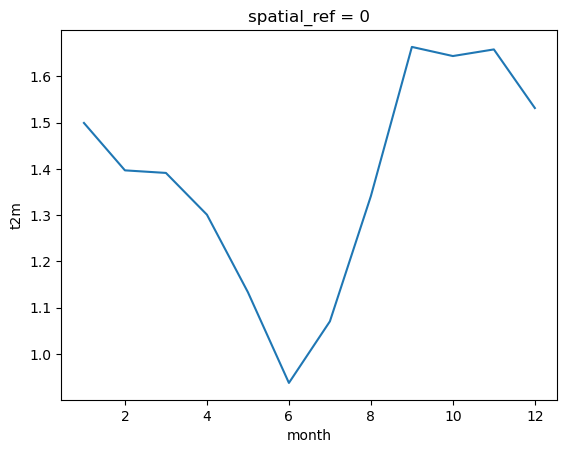

In [73]:
uhi_monthly.plot()

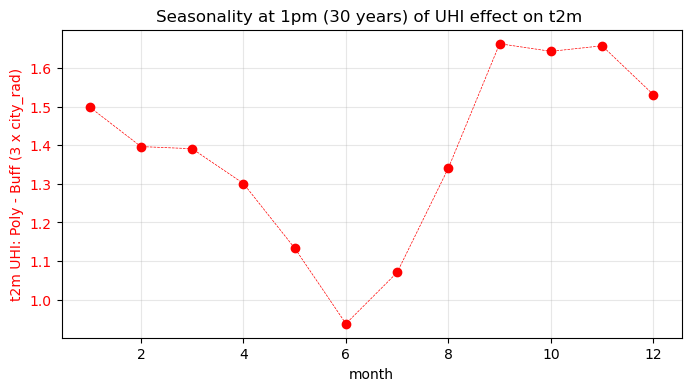

In [77]:
fig=plt.figure(figsize=(8, 4))

ax2=plt.subplot(111)
ax2.grid(alpha=0.3)
(uhi_monthly).plot(ax=ax2, linewidth=0.5, linestyle='--', marker='o',color='r', label='UHI')
plt.ylabel(f'{varname_era} UHI: Poly - Buff ({rat_buff} x city_rad)', color='r')
plt.tick_params(axis='y', labelcolor='r')
plt.title(f"Seasonality at 1pm (30 years) of UHI effect on {varname_era} ")

os.chdir('%s' %(plot_path))
plt.savefig(f'Seasonality_1pm_FromMonthly_{varname_era}_{city_name}_UHI.png', dpi=200, bbox_inches='tight')

## Finding latitude and longitude closest to city

In [25]:
abslat = np.abs(var_buff.latitude-city_lat)
abslon = np.abs(var_buff.longitude-city_lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))
yloc

np.int64(20)

In [75]:
var_city.latitude#

<xarray.DataArray 'latitude' (latitude: 40)> Size: 160B
array([-22.5 , -22.75, -23.  , -23.25, -23.5 , -23.75, -24.  , -24.25, -24.5 ,
       -24.75, -25.  , -25.25, -25.5 , -25.75, -26.  , -26.25, -26.5 , -26.75,
       -27.  , -27.25, -27.5 , -27.75, -28.  , -28.25, -28.5 , -28.75, -29.  ,
       -29.25, -29.5 , -29.75, -30.  , -30.25, -30.5 , -30.75, -31.  , -31.25,
       -31.5 , -31.75, -32.  , -32.25], dtype=float32)
Coordinates:
  * latitude     (latitude) float32 160B -22.5 -22.75 -23.0 ... -32.0 -32.25
    spatial_ref  int64 8B 0
Attributes:
    units:      degrees_north
    long_name:  latitude

In [ ]:
# var_buff.latitude#[20]

In [26]:
var_closest_lat = var_buff.isel(latitude=yloc)

In [ ]:
# var_closest_lat

In [27]:
var_closest_lat_djf=var_closest_lat.sel(time=var_closest_lat.time.dt.season == 'DJF').mean('time')

In [ ]:
# var_closest_lat_djf

In [ ]:
# var_closest_lat_djf.plot()

In [28]:
var_closest_lat_jja=var_closest_lat.sel(time=var_closest_lat.time.dt.season == 'JJA').mean('time')

In [29]:
var_closest_lat_all=var_closest_lat.mean('time')

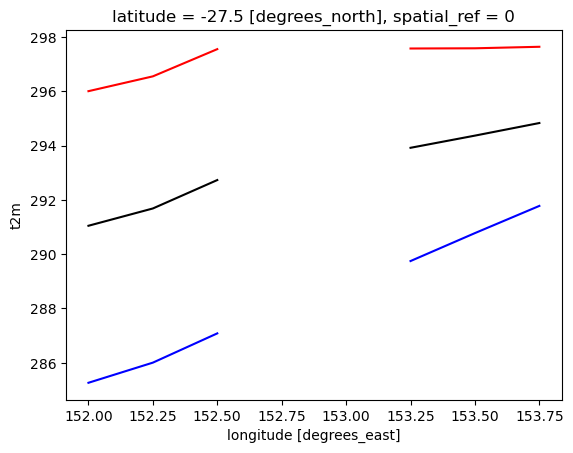

In [31]:
var_closest_lat_djf.plot(color='r', label='DJF')
var_closest_lat_jja.plot(color='b', label='JJA')
var_closest_lat_all.plot(color='k', label='ANN')